Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_0
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \delta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + (\eta - 1) (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{\delta \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [3]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [4]:
sa = 1
# Incoming radiation
Q0 = 342.5
## land fraction and albedo
#Fraction of land on the planet
p = 0.3

## outgoing radiation linearized
kappa = 1.74
Tkappa = 154
# Greenhouse effect parameter
B = 5.35

## Volcanism
Volcan = 0.028

## Biopump parameters
# Cbio_low = 150
# Cbio_high = 1000

Ts = 282.9
Cs = 275.5

#wa = 0.05
#cod = 0.15
alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 0.107
tauc = 20
coc0 =350
## Ocean albedo parameters
Talphaocean_low  = 219
Talphaocean_high = 299
alphaocean_max   = 0.84
alphaocean_min   = 0.255


Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5


# Ocean albedo
def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [40]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta = 0.01
eta = 0.032

# State variable
# Temperature anomaly
T_min = -20.
T_max =  20.
hT = 2.
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration
C_min = C0 - 200.
C_max = C0 + 200.
hC = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon
F_min = 0.
F_max = 200.
hF = 10.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(21, 41, 21)

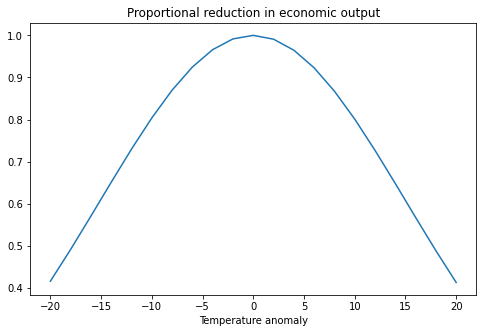

In [41]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

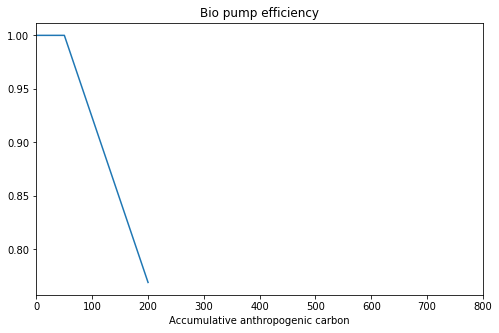

In [42]:
bio_pump_efficiency = biopump(F_grid)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon")
plt.title("Bio pump efficiency")
plt.xlim(0, 800)
plt.show()

In [47]:
v0 =  - delta *  F_mat**2

dG  = gamma_1 + gamma_2 * T_mat

epsilon  = 0.05
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 2000
fraction = 0.1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)

        

    Ca = - eta * delta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
       
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + T0) - Ro(T_mat + T0, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * (C_mat) * vegcover * veggrowth(T_mat +T0)
    B2 += oceanatmphysflux(T_mat + T0) * (1 - fracseaice(T_mat + T0))
    B2 += oceanbioflux(T_mat + T0, F_mat, sa) * (1 - fracseaice(T_mat + T0))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + T0))
    B3 = Ca
    C1 = np.zeros(T_mat.shape)
    C2 = np.zeros(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration %s: False Transient Error: %s; PDE Error %s" % (count, lhs_error, rhs_error))

print("Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

Iteration 1: False Transient Error: 1.5165164053098579; PDE Error 2.2575809204201036
Iteration 2: False Transient Error: 1.5152445830329953; PDE Error 2.256424968992633
Iteration 3: False Transient Error: 1.5139475727397667; PDE Error 2.2552426913922403
Iteration 4: False Transient Error: 1.5126280695051264; PDE Error 2.2540344433111876
Iteration 5: False Transient Error: 1.5112835241228595; PDE Error 2.2528005947399947
Iteration 6: False Transient Error: 1.5099170114336857; PDE Error 2.2515415284028855
Iteration 7: False Transient Error: 1.5085248477817004; PDE Error 2.250257641129462
Iteration 8: False Transient Error: 1.5071075065850437; PDE Error 2.2489493409608983
Iteration 9: False Transient Error: 1.5056654737315966; PDE Error 2.247617049191309
Iteration 10: False Transient Error: 1.5041992473493337; PDE Error 2.246261199167577
Iteration 11: False Transient Error: 1.5027093375141476; PDE Error 2.244882235999217
Iteration 12: False Transient Error: 1.5011962663550094; PDE Error 2

Iteration 101: False Transient Error: 1.3992746764245112; PDE Error 2.0980425030247076
Iteration 102: False Transient Error: 1.3985675006153997; PDE Error 2.09692625931401
Iteration 103: False Transient Error: 1.3978567943348708; PDE Error 2.0958334321708776
Iteration 104: False Transient Error: 1.3971430083410041; PDE Error 2.094764157844242
Iteration 105: False Transient Error: 1.396426125038488; PDE Error 2.0937185590499467
Iteration 106: False Transient Error: 1.3957064965495647; PDE Error 2.092696745476509
Iteration 107: False Transient Error: 1.3949836670025206; PDE Error 2.091698811221992
Iteration 108: False Transient Error: 1.394257180789964; PDE Error 2.090724839711548
Iteration 109: False Transient Error: 1.3935270717252024; PDE Error 2.089774898906967
Iteration 110: False Transient Error: 1.392793375652559; PDE Error 2.0888490444308694
Iteration 111: False Transient Error: 1.392090374373538; PDE Error 2.0879473149009975
Iteration 112: False Transient Error: 1.39138528239641

Iteration 201: False Transient Error: 1.3458791361676958; PDE Error 2.077813541540934
Iteration 202: False Transient Error: 1.3459656826188393; PDE Error 2.077939725573387
Iteration 203: False Transient Error: 1.3460369782836779; PDE Error 2.07805711802256
Iteration 204: False Transient Error: 1.346092660637055; PDE Error 2.078165348658114
Iteration 205: False Transient Error: 1.3461323869518083; PDE Error 2.078263991221842
Iteration 206: False Transient Error: 1.3461558238088855; PDE Error 2.078352664932247
Iteration 207: False Transient Error: 1.3461626475964295; PDE Error 2.078430987610755
Iteration 208: False Transient Error: 1.3461525447161193; PDE Error 2.0784985839009593
Iteration 209: False Transient Error: 1.3461252117394906; PDE Error 2.078555085613445
Iteration 210: False Transient Error: 1.3460803556472456; PDE Error 2.0786001320425385
Iteration 211: False Transient Error: 1.3460176940253632; PDE Error 2.0786333697157104
Iteration 212: False Transient Error: 1.3459369552572

Iteration 296: False Transient Error: 1.2791639266629318; PDE Error 2.0232459829100264
Iteration 297: False Transient Error: 1.277851103645844; PDE Error 2.021998252739774
Iteration 298: False Transient Error: 1.276532248211879; PDE Error 2.0222880663394918
Iteration 299: False Transient Error: 1.2752381671208468; PDE Error 2.025262981329682
Iteration 300: False Transient Error: 1.2739546488109; PDE Error 2.02793007709532
Iteration 301: False Transient Error: 1.2726976805663526; PDE Error 2.030291920258275
Iteration 302: False Transient Error: 1.2714501968474679; PDE Error 2.0323529557392632
Iteration 303: False Transient Error: 1.2702375778712849; PDE Error 2.0341193834757085
Iteration 304: False Transient Error: 1.2690340053757154; PDE Error 2.0355990271922018
Iteration 305: False Transient Error: 1.2678641489486608; PDE Error 2.0368011966858965
Iteration 306: False Transient Error: 1.2667148189274258; PDE Error 2.0377365450828293
Iteration 307: False Transient Error: 1.2655821346487

Iteration 397: False Transient Error: 1.2045264427035818; PDE Error 1.992004200772513
Iteration 398: False Transient Error: 1.2039110533433472; PDE Error 1.9895718019117865
Iteration 399: False Transient Error: 1.2032937444143954; PDE Error 1.9884552991957989
Iteration 400: False Transient Error: 2.8107277275589837; PDE Error 1.9873268179923542
Iteration 401: False Transient Error: 1.2020776099234354; PDE Error 1.9861880044588105
Iteration 402: False Transient Error: 1.2014711797505129; PDE Error 1.9850404631311882
Iteration 403: False Transient Error: 1.2008632605994762; PDE Error 1.9838857419315339
Iteration 404: False Transient Error: 1.200253426085851; PDE Error 1.982725348887275
Iteration 405: False Transient Error: 1.19964166113391; PDE Error 1.9815607456878226
Iteration 406: False Transient Error: 1.1990280082079607; PDE Error 1.980393334925413
Iteration 407: False Transient Error: 1.19841838048103; PDE Error 1.9792244675689474
Iteration 408: False Transient Error: 1.19781595115

Iteration 494: False Transient Error: 1.165350528997351; PDE Error 2.039737833417764
Iteration 495: False Transient Error: 1.1649082294775326; PDE Error 2.0576944567248177
Iteration 496: False Transient Error: 1.1644534051754363; PDE Error 2.0738321582734898
Iteration 497: False Transient Error: 1.1639860392114088; PDE Error 2.088036829141217
Iteration 498: False Transient Error: 1.16350612224835; PDE Error 2.100221917356002
Iteration 499: False Transient Error: 1.163013652356426; PDE Error 2.1103283770210197
Iteration 500: False Transient Error: 1.1625086349346248; PDE Error 2.1183242492939414
Iteration 501: False Transient Error: 1.1619910826738078; PDE Error 2.1242039009767595
Iteration 502: False Transient Error: 1.161461015423697; PDE Error 2.127986948648868
Iteration 503: False Transient Error: 1.1609184604554912; PDE Error 2.1297168987647908
Iteration 504: False Transient Error: 1.1603634519144634; PDE Error 2.129459539071611
Iteration 505: False Transient Error: 1.1597960311257

Iteration 591: False Transient Error: 1.092810092208083; PDE Error 2.0008670992117494
Iteration 592: False Transient Error: 1.092247768376069; PDE Error 2.0013919297260294
Iteration 593: False Transient Error: 1.0916845520415563; PDE Error 2.0019146533711236
Iteration 594: False Transient Error: 1.0911203425206395; PDE Error 2.002435597516392
Iteration 595: False Transient Error: 1.0905548634454476; PDE Error 2.0029549315386284
Iteration 596: False Transient Error: 1.0899879462510853; PDE Error 2.0034726260990716
Iteration 597: False Transient Error: 1.0894196106630716; PDE Error 2.0039884087949567
Iteration 598: False Transient Error: 1.088849877351663; PDE Error 2.0045017164131202
Iteration 599: False Transient Error: 1.088293849840909; PDE Error 2.005011644114198
Iteration 600: False Transient Error: 1.0877435178673522; PDE Error 2.0055168922036835
Iteration 601: False Transient Error: 1.0871917497269123; PDE Error 2.006015710845187
Iteration 602: False Transient Error: 1.0866386130

Iteration 688: False Transient Error: 1.040292136716232; PDE Error 2.1511549184047993
Iteration 689: False Transient Error: 1.0397701014920813; PDE Error 2.174802143994853
Iteration 690: False Transient Error: 1.039248131004058; PDE Error 2.1981226342134796
Iteration 691: False Transient Error: 1.0387259130666848; PDE Error 2.2209622179528203
Iteration 692: False Transient Error: 1.0382037295687496; PDE Error 2.2431661992341922
Iteration 693: False Transient Error: 1.037683396581599; PDE Error 2.264580553071827
Iteration 694: False Transient Error: 1.0371620488436406; PDE Error 2.2850531412732167
Iteration 695: False Transient Error: 1.0366396934313116; PDE Error 2.304434915847306
Iteration 696: False Transient Error: 1.0361163380565586; PDE Error 2.322581134870042
Iteration 697: False Transient Error: 1.0355937085824962; PDE Error 2.3393525424824126
Iteration 698: False Transient Error: 1.0350741047642487; PDE Error 2.35461652413003
Iteration 699: False Transient Error: 1.034553502259

Iteration 785: False Transient Error: 1.0015550129728013; PDE Error 2.1550142944289234
Iteration 786: False Transient Error: 1.0009877308846171; PDE Error 2.166926774009191
Iteration 787: False Transient Error: 1.0004196442187663; PDE Error 2.1774665836057068
Iteration 788: False Transient Error: 0.999850593955216; PDE Error 2.1866215178700728
Iteration 789: False Transient Error: 0.9992796774656654; PDE Error 2.194387600475352
Iteration 790: False Transient Error: 0.9987053462711515; PDE Error 2.2007688660174267
Iteration 791: False Transient Error: 0.9981267703835783; PDE Error 2.2057770966162273
Iteration 792: False Transient Error: 0.9975434541183859; PDE Error 2.209431516311099
Iteration 793: False Transient Error: 0.9969550966178531; PDE Error 2.2117584466104283
Iteration 794: False Transient Error: 0.9963620002520202; PDE Error 2.2127909271644555
Iteration 795: False Transient Error: 0.9957632008658379; PDE Error 2.212568303328659
Iteration 796: False Transient Error: 0.99515932

Iteration 884: False Transient Error: 69.26321514408059; PDE Error 73.9930515498503
Iteration 885: False Transient Error: 64.74956628174212; PDE Error 68.85988901877452
Iteration 886: False Transient Error: 60.27183299318814; PDE Error 64.01798627101897
Iteration 887: False Transient Error: 55.90885308156382; PDE Error 59.3101247513009
Iteration 888: False Transient Error: 51.60394915414777; PDE Error 54.74206427487157
Iteration 889: False Transient Error: 47.33731255376206; PDE Error 50.212051691844536
Iteration 890: False Transient Error: 43.10694874721232; PDE Error 45.63863864907036
Iteration 891: False Transient Error: 38.96493497425812; PDE Error 41.0981839427918
Iteration 892: False Transient Error: 34.94050007404141; PDE Error 36.65664118440007
Iteration 893: False Transient Error: 31.05303681249964; PDE Error 33.03791513401564
Iteration 894: False Transient Error: 27.36008515571477; PDE Error 29.576097878358844
Iteration 895: False Transient Error: 23.861383855337266; PDE Erro

Iteration 982: False Transient Error: 0.8983363787936582; PDE Error 1.9562279705734795
Iteration 983: False Transient Error: 0.898091776251988; PDE Error 1.955769879321977
Iteration 984: False Transient Error: 0.8978452738395504; PDE Error 1.955328208288151
Iteration 985: False Transient Error: 0.8975967625391945; PDE Error 1.95490319564788
Iteration 986: False Transient Error: 0.8973461362609214; PDE Error 1.9544950165744908
Iteration 987: False Transient Error: 0.8970932910932561; PDE Error 1.9541037874457636
Iteration 988: False Transient Error: 0.8968381255513691; PDE Error 1.9537295707326479
Iteration 989: False Transient Error: 0.8965805405375704; PDE Error 1.9533723796937856
Iteration 990: False Transient Error: 0.8963204393305091; PDE Error 1.9530321833435416
Iteration 991: False Transient Error: 0.8960577275516357; PDE Error 1.953109038480477
Iteration 992: False Transient Error: 0.8957923131532652; PDE Error 1.9532065359638011
Iteration 993: False Transient Error: 0.895524106

Iteration 1076: False Transient Error: 0.8607046074817504; PDE Error 1.9772691098101411
Iteration 1077: False Transient Error: 0.8601594755745623; PDE Error 1.9764644659859911
Iteration 1078: False Transient Error: 0.8596118934386254; PDE Error 1.9754538695132275
Iteration 1079: False Transient Error: 0.8590619402750121; PDE Error 1.9742403297157978
Iteration 1080: False Transient Error: 0.8585096965236971; PDE Error 1.9728297052374018
Iteration 1081: False Transient Error: 0.8579552435966775; PDE Error 1.9712307191172052
Iteration 1082: False Transient Error: 0.8573986641164311; PDE Error 1.96945491978299
Iteration 1083: False Transient Error: 0.856840041018927; PDE Error 1.967550832354867
Iteration 1084: False Transient Error: 0.8562794580006994; PDE Error 1.9659541546059742
Iteration 1085: False Transient Error: 0.8557169993872549; PDE Error 1.9642432845909994
Iteration 1086: False Transient Error: 0.8558686296117379; PDE Error 1.9624273388576938
Iteration 1087: False Transient Erro

Iteration 1172: False Transient Error: 3.7171030673022187; PDE Error 5.756687349188429
Iteration 1173: False Transient Error: 3.440113673581777; PDE Error 5.53470570801143
Iteration 1174: False Transient Error: 3.141390142791778; PDE Error 5.289213401128357
Iteration 1175: False Transient Error: 2.824403528708075; PDE Error 5.021862224354695
Iteration 1176: False Transient Error: 2.49072437229799; PDE Error 4.734489092654204
Iteration 1177: False Transient Error: 2.1425749186852983; PDE Error 4.429099185605306
Iteration 1178: False Transient Error: 2.3187165244220864; PDE Error 4.107847430714852
Iteration 1179: False Transient Error: 2.50495484762844; PDE Error 3.7730188636176543
Iteration 1180: False Transient Error: 2.7413260625799296; PDE Error 3.4270074643766364
Iteration 1181: False Transient Error: 2.957043581650751; PDE Error 3.2197433296409717
Iteration 1182: False Transient Error: 3.2249956566196403; PDE Error 3.452245843525387
Iteration 1183: False Transient Error: 3.50656394

Iteration 1271: False Transient Error: 0.8065079275331755; PDE Error 1.9527136017356561
Iteration 1272: False Transient Error: 0.8220675247856235; PDE Error 1.9532574418851816
Iteration 1273: False Transient Error: 0.8314280254992923; PDE Error 1.9537955210262439
Iteration 1274: False Transient Error: 0.8349345920935747; PDE Error 1.9543277311975196
Iteration 1275: False Transient Error: 0.8329509932588763; PDE Error 1.9548541172760636
Iteration 1276: False Transient Error: 0.8258555635234899; PDE Error 1.9553748133185387
Iteration 1277: False Transient Error: 0.814037333365647; PDE Error 1.9558899869772794
Iteration 1278: False Transient Error: 0.7978923416692396; PDE Error 1.956399792452686
Iteration 1279: False Transient Error: 0.7778201667864693; PDE Error 1.9576653468361798
Iteration 1280: False Transient Error: 0.776563012325937; PDE Error 1.9602682788199282
Iteration 1281: False Transient Error: 0.7762304223408023; PDE Error 1.962943334006468
Iteration 1282: False Transient Erro

Iteration 1366: False Transient Error: 0.7410947780459765; PDE Error 2.0257445910928347
Iteration 1367: False Transient Error: 0.7406586405107873; PDE Error 2.009888676943497
Iteration 1368: False Transient Error: 0.7402272178052272; PDE Error 1.9945503678254966
Iteration 1369: False Transient Error: 0.7397983806899333; PDE Error 1.9798994522823428
Iteration 1370: False Transient Error: 0.7393729579737851; PDE Error 1.9712370183592078
Iteration 1371: False Transient Error: 0.7389524691214433; PDE Error 1.9725895554318136
Iteration 1372: False Transient Error: 0.738535049312361; PDE Error 1.9741523601821669
Iteration 1373: False Transient Error: 0.7381208434847508; PDE Error 1.9759141653723624
Iteration 1374: False Transient Error: 0.7377114804378948; PDE Error 1.9778613807288217
Iteration 1375: False Transient Error: 0.7373058824731515; PDE Error 1.9799778135353385
Iteration 1376: False Transient Error: 0.7369033060544439; PDE Error 1.98224438791868
Iteration 1377: False Transient Erro

Iteration 1463: False Transient Error: 0.7052426609303097; PDE Error 2.398330274242337
Iteration 1464: False Transient Error: 0.7048891171999117; PDE Error 2.379092672766923
Iteration 1465: False Transient Error: 0.7045354589169506; PDE Error 2.356460243054322
Iteration 1466: False Transient Error: 0.7041816881337581; PDE Error 2.330623149790636
Iteration 1467: False Transient Error: 0.703828280336154; PDE Error 2.301804126217945
Iteration 1468: False Transient Error: 0.7034762536039807; PDE Error 2.2702561622211164
Iteration 1469: False Transient Error: 0.7031241689688272; PDE Error 2.236259848185565
Iteration 1470: False Transient Error: 0.7027720202796672; PDE Error 2.2001204105741614
Iteration 1471: False Transient Error: 0.7024197600679827; PDE Error 2.1621644702154903
Iteration 1472: False Transient Error: 0.702067648222453; PDE Error 2.122736569720459
Iteration 1473: False Transient Error: 0.7017162222078355; PDE Error 2.0821955095390017
Iteration 1474: False Transient Error: 0.

Iteration 1559: False Transient Error: 0.6746442770952399; PDE Error 1.9524528615256642
Iteration 1560: False Transient Error: 0.6743176169769072; PDE Error 1.9369323465891028
Iteration 1561: False Transient Error: 0.6739894326310036; PDE Error 1.9222688329330957
Iteration 1562: False Transient Error: 0.6736597270116818; PDE Error 1.9235188614322425
Iteration 1563: False Transient Error: 0.6733285038399117; PDE Error 1.9255968092430678
Iteration 1564: False Transient Error: 0.6729957674494358; PDE Error 1.9279371406750379
Iteration 1565: False Transient Error: 0.6726615235649547; PDE Error 1.9305340639471247
Iteration 1566: False Transient Error: 0.6723257775530556; PDE Error 1.9333799196800179
Iteration 1567: False Transient Error: 0.6719885361664524; PDE Error 1.9364651996971318
Iteration 1568: False Transient Error: 0.6716498073589605; PDE Error 1.939778581362738
Iteration 1569: False Transient Error: 0.6713095989837825; PDE Error 1.9433069771088363
Iteration 1570: False Transient E

Iteration 1654: False Transient Error: 0.6409976113249627; PDE Error 1.9666311319620533
Iteration 1655: False Transient Error: 0.6406747819312386; PDE Error 1.9670278863924153
Iteration 1656: False Transient Error: 0.6403518855552193; PDE Error 1.9673738002047578
Iteration 1657: False Transient Error: 0.6400289261441117; PDE Error 1.9676697595162196
Iteration 1658: False Transient Error: 0.6397059056388343; PDE Error 1.9679171155520372
Iteration 1659: False Transient Error: 0.6393843464331894; PDE Error 1.9681176236996691
Iteration 1660: False Transient Error: 0.6390641376160033; PDE Error 1.9682733838264
Iteration 1661: False Transient Error: 0.6387438625014852; PDE Error 1.96838678243871
Iteration 1662: False Transient Error: 0.638423522620144; PDE Error 1.968460437160818
Iteration 1663: False Transient Error: 0.6381031812338733; PDE Error 1.9684971440620131
Iteration 1664: False Transient Error: 0.6377827963632399; PDE Error 1.9684998281822779
Iteration 1665: False Transient Error: 

Iteration 1751: False Transient Error: 0.7583474906940069; PDE Error 2.005345716569142
Iteration 1752: False Transient Error: 0.7292772886966503; PDE Error 2.0044296244034285
Iteration 1753: False Transient Error: 0.7268671726870846; PDE Error 2.0021912113446234
Iteration 1754: False Transient Error: 0.6891558161136402; PDE Error 1.9986195537258347
Iteration 1755: False Transient Error: 0.6685703388816933; PDE Error 1.9937389055945225
Iteration 1756: False Transient Error: 0.6453602536947045; PDE Error 1.999901210010691
Iteration 1757: False Transient Error: 0.61725739272525; PDE Error 2.0071700510217987
Iteration 1758: False Transient Error: 0.6216665024360424; PDE Error 2.013674087678485
Iteration 1759: False Transient Error: 0.6467740947571698; PDE Error 2.0193491176976863
Iteration 1760: False Transient Error: 0.6898855765680167; PDE Error 2.0241444820322734
Iteration 1761: False Transient Error: 0.7279642899029071; PDE Error 2.028023477250052
Iteration 1762: False Transient Error:

Iteration 1846: False Transient Error: 0.5836517345125003; PDE Error 2.3173578427910044
Iteration 1847: False Transient Error: 0.5833514882834834; PDE Error 2.3090334697295702
Iteration 1848: False Transient Error: 0.583051169712121; PDE Error 2.2971490463588395
Iteration 1849: False Transient Error: 0.5827507354604222; PDE Error 2.2819258529193114
Iteration 1850: False Transient Error: 0.58245007731756; PDE Error 2.263631549683872
Iteration 1851: False Transient Error: 0.5821489797745016; PDE Error 2.2425748078701275
Iteration 1852: False Transient Error: 0.5818473789275913; PDE Error 2.234951209266505
Iteration 1853: False Transient Error: 0.5815452593583359; PDE Error 2.258063524698951
Iteration 1854: False Transient Error: 0.5812425590701764; PDE Error 2.277598202854662
Iteration 1855: False Transient Error: 0.5809392067334329; PDE Error 2.2935895503388437
Iteration 1856: False Transient Error: 0.5806353181637292; PDE Error 2.306100953851029
Iteration 1857: False Transient Error: 0

Iteration 1945: False Transient Error: 216.26197927377336; PDE Error 248.797995733817
Iteration 1946: False Transient Error: 176.36931161854795; PDE Error 207.30484548583829
Iteration 1947: False Transient Error: 141.81732148053845; PDE Error 170.46384587864432
Iteration 1948: False Transient Error: 111.92411685970349; PDE Error 138.06488979093461
Iteration 1949: False Transient Error: 86.53809837306653; PDE Error 109.84922348513956
Iteration 1950: False Transient Error: 65.0925443375052; PDE Error 85.52421005970037
Iteration 1951: False Transient Error: 52.46986442337871; PDE Error 64.77541163840152
Iteration 1952: False Transient Error: 52.68429875863376; PDE Error 52.469665716886446
Iteration 1953: False Transient Error: 51.48187020730191; PDE Error 52.684133124508804
Iteration 1954: False Transient Error: 49.22676615503178; PDE Error 51.48173257997161
Iteration 1955: False Transient Error: 46.224951124236924; PDE Error 49.226651108180675
Iteration 1956: False Transient Error: 42.72

In [48]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max()

(29.572050503923947,
 -368.8647839387868,
 -76.32473993061369,
 -23.525965167939123,
 -1.708315067576728,
 1.0000000000000002e-32,
 9.343684900278008)

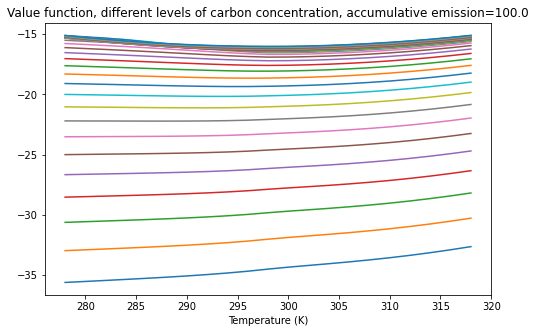

In [51]:
plt.plot(T_grid + T0, v0[:, :,10])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[10]))
plt.show()

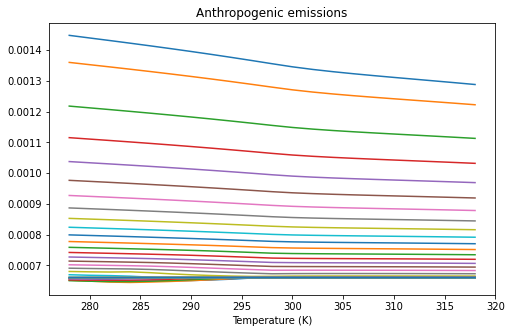

In [52]:
plt.plot(T_grid + T0, Ca[:, :, -3])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()